### Sparse Linear Operator
This is an example of how to create and tune a sparse linear operator.

In [1]:
import torch
import matplotlib.pyplot as plt
import sparta

First, we need to create a PyTorch dense linear operator. Suppose the input dimension is K, the output dimension is N and the batch size is M.

Note that the optimal implementation and configuration are different for different batch sizes, so we need to determine the batch size at the very early stage.

In [2]:
M, K, N = 1024, 1024, 1024
dense_linear = torch.nn.Linear(K, N).cuda()

To build a linear operator with sparse weights, a weight mask tensor is required.

Let's generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

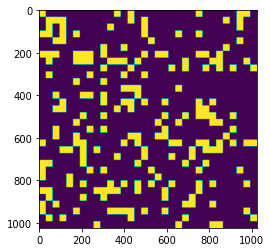

In [3]:
weight_mask = sparta.testing.block_mask((N, K), block=(32, 32), sparsity=0.8).cuda()
plt.imshow(weight_mask.cpu().numpy())

Create a ```sparta.nn.SparseLinear``` operator using the dense operator and the weight mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take half an hour.

In [4]:
x = torch.rand((M, K)).cuda()
sparse_linear = sparta.nn.SparseLinear(dense_linear, weight_mask=weight_mask)
sparta.nn.tune(sparse_linear, sample_inputs=[x])

==================== Tuning ====================
----- Implementation: sparta; Search space: 729 -----
#1: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_SIZE_N_VALUE=16, BLOCK_SIZE_M_VALUE=16
Latency: 0.261792 ms
#2: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_SIZE_N_VALUE=16, BLOCK_SIZE_M_VALUE=32
An error occured
#3: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_SIZE_N_VALUE=16, BLOCK_SIZE_M_VALUE=64
An error occured
#4: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_SIZE_N_VALUE=32, BLOCK_SIZE_M_VALUE=16
An error occured
#5: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_SIZE_N_VALUE=32, BLOCK_SIZE_M_VALUE=32
An error occured
#6: THREAD_SIZE_K_VALUE=2, THREAD_SIZE_N_VALUE=2, THREAD_SIZE_M_VALUE=2, BLOCK_SIZE_K_VALUE=16, BLOCK_S

Let's check whether the sparse operator works correctly.

In [5]:
dense_linear.weight = torch.nn.Parameter(dense_linear.weight.detach() * weight_mask)
torch.testing.assert_allclose(sparse_linear(x), dense_linear(x))

Finally, take a look at how much time can be saved by using the sparse linear operator!

In [6]:
dense_latency = sparta.testing.test_latency(dense_linear, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_linear, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')

Dense linear operator latency: 0.3665568113327026 ms
Sparse linear operator latency: 0.30163838863372805 ms
